# Logistic model

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
from glob import glob

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [2]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

,Unnamed: 0,species,median_counts,mean_counts,1,8,9,10,15,17,...,1001,1004,1010,1016,1022,1028,1029,1035,1039,1044
0,0,Prevotella sp. Smarlab 121567,412.0,415.156682,0,0,0,2,10,18,...,220,248,252,286,346,293,277,190,222,364
1,1,Parabacteroides distasonis,205.5,206.709677,0,0,0,2,41,145,...,136,157,206,133,177,105,163,147,208,222
2,3,Barnesiella intestinihominis,142.0,145.419355,0,0,0,1,19,58,...,158,145,184,131,145,154,119,130,71,161
3,4,Barnesiella viscericola,125.5,137.092166,0,1,0,1,112,195,...,66,85,134,96,126,121,92,71,72,147
4,2,Lactobacillus taiwanensis,123.5,174.769585,0,422,309,0,48,15,...,36,162,282,174,100,306,517,193,513,175


In [3]:
# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(10) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [4]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities")  # Construct the path Data/dissimilarities in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,2): 
        df = mi.get_dissimilarities(mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [5]:
# Check that it was built correctly considering for example the first mouse
mice_diss[0].head()

,1,2,3,4,5,6,7,8,9,10,...,1027,1028,1029,1030,1031,1034,1035,1036,1038,1043
Prevotella sp. Smarlab 121567,0.152198,0.171746,0.062899,0.094635,0.111559,0.100248,0.159679,0.158560,0.198151,0.141593,...,0.940133,1.0,0.930256,1.000000,1.000000,0.989131,1.000000,1.000000,1.0,1.0
Parabacteroides distasonis,0.063016,0.084766,0.051827,0.052748,0.085593,0.070336,0.085282,0.074986,0.091216,0.080886,...,0.681340,1.0,0.717952,1.000000,1.000000,0.982302,1.000000,1.000000,1.0,1.0
Barnesiella intestinihominis,0.137988,0.090815,0.087523,0.109374,0.123000,0.083900,0.144142,0.103052,0.126055,0.137472,...,0.740400,1.0,0.783781,1.000000,1.000000,0.987731,1.000000,1.000000,1.0,1.0
Barnesiella viscericola,0.160086,0.079281,0.060972,0.120502,0.157528,0.097143,0.143658,0.096437,0.122690,0.106828,...,0.654971,1.0,0.482109,1.000000,0.945956,0.986578,1.000000,0.973156,1.0,1.0
Lactobacillus taiwanensis,0.378027,0.294579,0.240163,0.315811,0.377685,0.302834,0.428027,0.476685,0.378278,0.271188,...,0.615931,1.0,0.662169,0.061591,0.009472,1.000000,0.076651,0.171177,1.0,1.0


Let's now have a graphical visualization of these dissimilarities

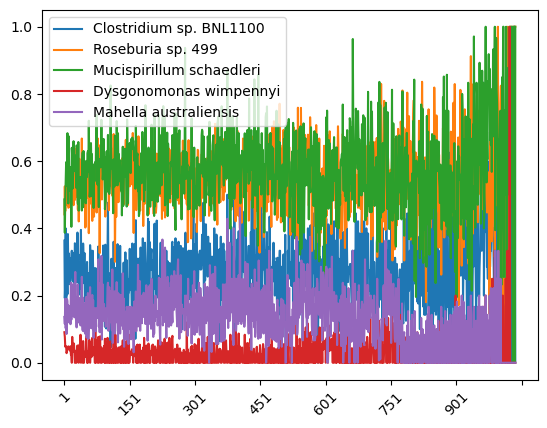

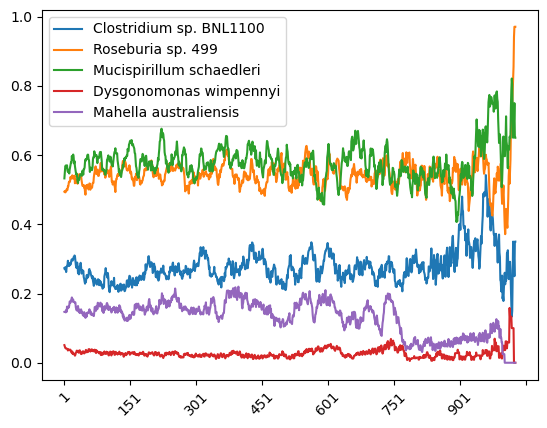

In [6]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): 
    #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
    
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()   

##DA METTERE NOME SUGLI ASSI

In [7]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

Plots saved in Inspection_Outputs\dissimilarity_1_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_2_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_3_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_4_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_5_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_6_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_7_plot.pdf
Plots saved in Inspection_Outputs\dissimilarity_8_plot.pdf


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [8]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

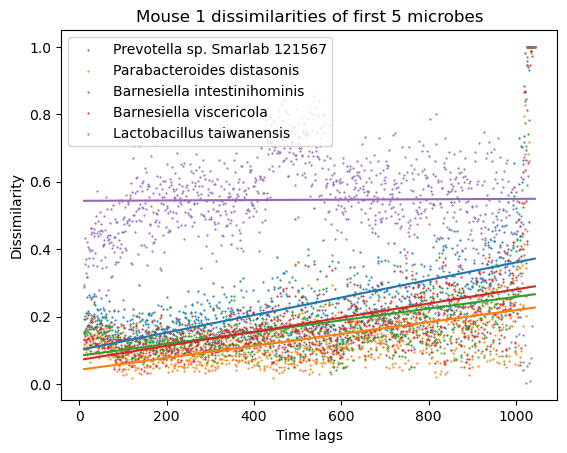

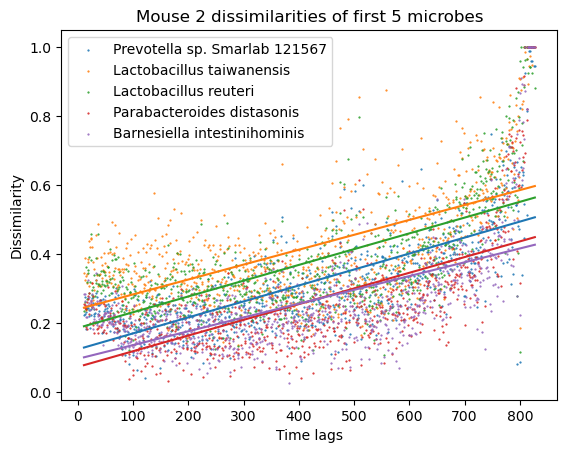

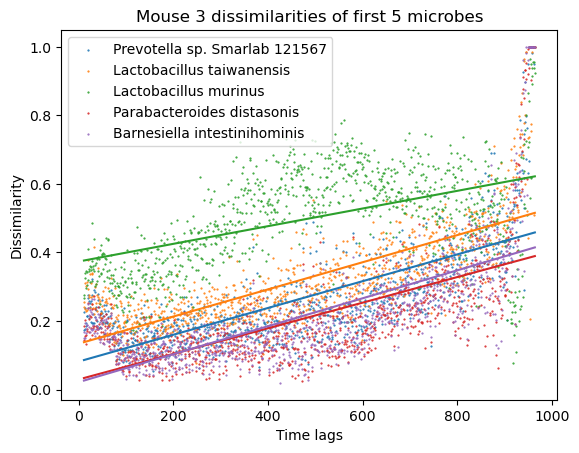

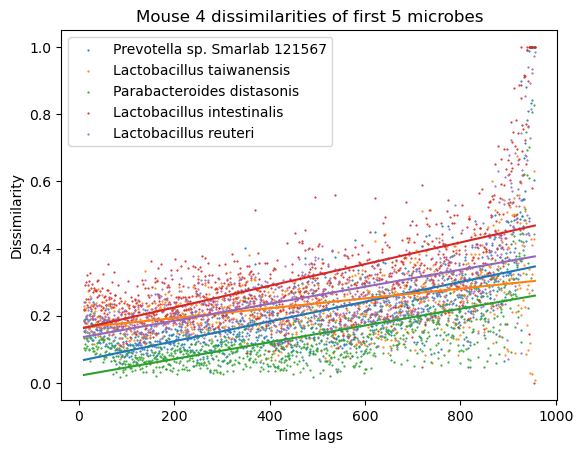

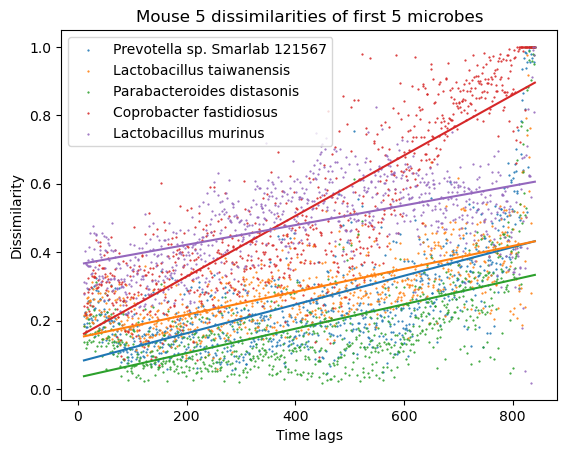

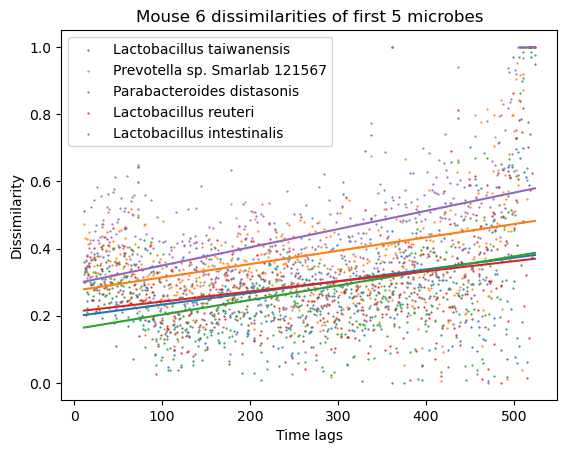

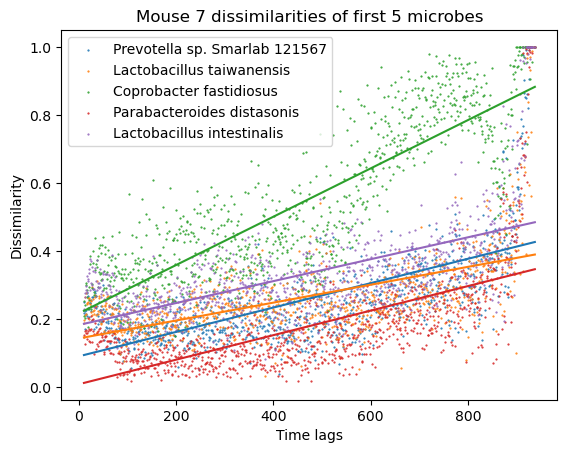

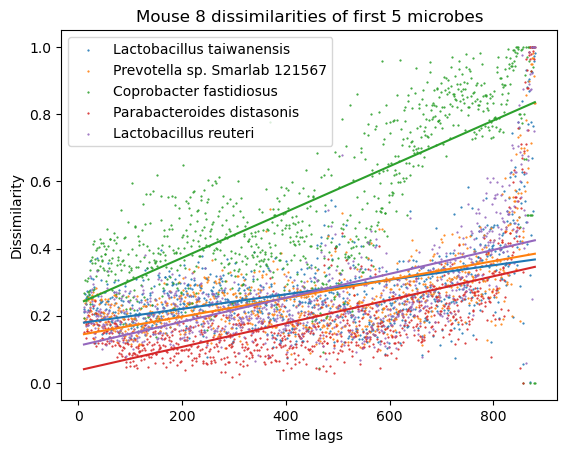

In [9]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()


##MOSTRIAMONE 1, salviamo gli altri


## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

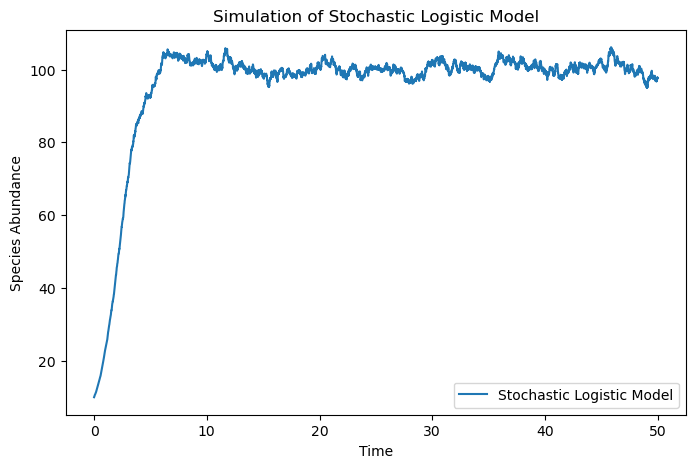

In [207]:
# Define the function to simulate a stochastic logistic model

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]

        #--------- useful print for eventual debugging-----------------#
        growth_term = (ab/tau) * (1 - (ab / K))
        noise_term = ab * np.sqrt(sigma/tau) * np.random.normal()
        update = (growth_term + noise_term) * dt[t-1]

        #print(f"Step {t}: ab={ab}, growth={growth_term}, noise={noise_term}, update={update}")

        #--------------------------------------------------------------# 
        
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        #ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
        ab_vals[t] = max(0, ab_vals[t])
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 

#### NOTICE: 
Our aim is to generate data from a Stochastic Logistic Model that could be consistent with the data. 
Therefore, we need to estimate what are the values of K and sigma that we expect from the data. 
To do this, we can use the theoretical relationships known for the average abundance and standard deviation of the abundance at stationarity (when sigma < 2).

"The model does not include interaction among species and therefore cannot reproduce patterns of interspecies correlation but correctly reproduces several patterns of the dynamics of a single species (15, 16).  

If $\sigma < 2$, the stationary distribution is gamma:

$$
P(\lambda; K, \sigma) = \frac{1}{\Gamma(2/\sigma - 1)} \left( \frac{2 - \sigma}{K} \right)^{\frac{2}{\sigma} -1} \lambda^{\frac{2}{\sigma} -2} e^{-\frac{2}{\sigma K} \lambda}
$$

with mean  

$$
\langle \lambda \rangle = K \frac{2 - \sigma}{\sigma}
$$  

and variance  

$$
\text{var}(\lambda) = \frac{\langle \lambda \rangle^2}{2 - \sigma}.
$$  

" (from the article). 

Hence we must: 

- Find the transient to stationarity and discard it (this can be done by fitting the data with a non-stochastic logistic model, which also gives us a hint of the parameter K); 

- Compute mean and standard deviation of the collected abundances (data); 

- Estimate the parameters from the theoretical values. 

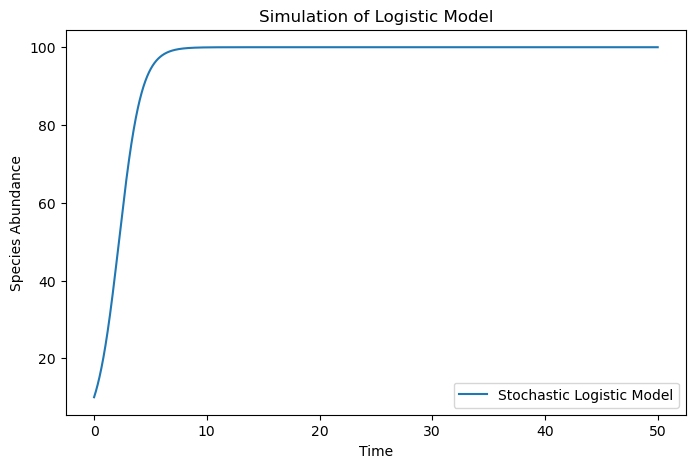

In [11]:
# DEFINE THE LOGISTIC MODEL FUNCTION

def LM(ab0, K, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + (ab/tau)*(1 - (ab / K)) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
       
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = LM(ab0, K, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Logistic Model")
plt.legend()
plt.show()

In [12]:
# PREPARE DATA FOR THE FIT (we want to fit abundancies, our epirical  time series)
# Let's get the data cleaning it from the columns that do not correspond to species names or abundancies
# Indeed if you print(mi.mice_df) you see there are other information not needed here

mice_ab = []
for mouse_num in range(len(mi.mice_df)): 
    columns = mi.mice_df[mouse_num].columns
    mice_ab.append(mi.mice_df[mouse_num].drop(columns = ['Unnamed: 0', 'median_counts', 'mean_counts']))
print(mice_ab[0])

                           species  1    8    9  10   15   17   20   21    22  \
0    Prevotella sp. Smarlab 121567  0    0    0   2   10   18   21   33     3   
1       Parabacteroides distasonis  0    0    0   2   41  145   43   58    54   
2     Barnesiella intestinihominis  0    0    0   1   19   58   28   52    14   
3          Barnesiella viscericola  0    1    0   1  112  195    8   15     5   
4        Lactobacillus taiwanensis  0  422  309   0   48   15  999  156  1096   
..                             ... ..  ...  ...  ..  ...  ...  ...  ...   ...   
621          Mahella australiensis  0    0    0   0    0    0    0    0     0   
622       Prevotella sp. P2A_FAAD4  0    0    0   0    0    0    0    0     0   
623            Xylanibacter oryzae  0    0    0   0    0    0    0    0     0   
624        Thioflavicoccus mobilis  0    0    0   0    0    0    0    0     0   
625        Prevotella paludivivens  0    0    0   0    0    0    0    0     0   

     ...  1001  1004  1010 

#### TRIAL FOR FIRST MICE AND FIRST SPECIES

In [ ]:
# FIT TO GET THE VALUE OF K

# Load the first mouse's data
df = mice_ab[0]
species = df['species']
ts_data = df.iloc[0, 1:].to_numpy()
nonzero = np.nonzero(ts_data)[0]
start_idx = nonzero[0] + 1  # Adjust for skipped species column if needed
time_series = df.iloc[0, start_idx:].to_numpy()  # Extract the first species' time series
days = np.asarray(df.columns[start_idx:], dtype=int)  # Get measurement days
dt = np.diff(days)  # Compute time intervals

# Objective function for optimization
def objective(params, time_series, dt):
    K, tau = params
    simulated_data = LM(
                ab0=time_series[0], 
                K=K, 
                tau=tau, 
                steps=len(time_series)-1,
                dt=dt)
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

# Define parameter bounds
bounds_K = (1, 1e3)  # Carrying capacity
bounds_tau = (0.5, 1.5)  # Timescale parameter
bounds = [bounds_K, bounds_tau]

# Step 1: Use Differential Evolution for Global Search
result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

K_opt, tau_opt = result.x
print(f"Estimated K: {K_opt}")
print(f"Estimated tau: {tau_opt}")

""" --> useless 'cause we get the same
# Step 2: Use L-BFGS-B for Local Refinement
result_refined = opt.minimize(objective, [K_opt, tau_opt], args=(time_series, dt),
                              method='L-BFGS-B', bounds=bounds)

K_opt, tau_opt = result_refined.x
print("\nAfter L-BFGS-B Refinement:")
print(f"Refined K: {K_opt}")
print(f"Refined tau: {tau_opt}")

"""
# Simulate data using refined parameters
fitted_data = LM(
    ab0=time_series[0], K=K_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.xlim(0,100) 
plt.legend()
plt.show()

In [15]:
# GET RID OF TRANSIENT

# Get rid of the first forty samples --> this way to consider only data at "stationarity"
# Discard the initial transient 
df_red = df.drop(df.columns[:40], axis=1)
df_red

,86,90,97,104,111,125,133,139,147,153,...,1001,1004,1010,1016,1022,1028,1029,1035,1039,1044
0,1031,896,355,168,437,759,751,381,384,482,...,220,248,252,286,346,293,277,190,222,364
1,247,202,258,167,237,430,303,203,230,297,...,136,157,206,133,177,105,163,147,208,222
2,251,215,138,13,117,126,128,85,132,215,...,158,145,184,131,145,154,119,130,71,161
3,156,66,99,59,163,140,152,97,131,175,...,66,85,134,96,126,121,92,71,72,147
4,15,1,39,135,23,328,1,25,0,0,...,36,162,282,174,100,306,517,193,513,175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
623,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
624,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [16]:
# ESTIMATE THE VALUES OF K AND SIGMA FROM THEORY 
var=np.var(time_series)
mean=np.mean(time_series)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

Theoretical K: 521.8080205070935
Theoretical sigma: 0.39021255521582965


In [ ]:
# GENERATE SYNTHETIC DATA USING SLM 

# Parameters
ab0 = df.iloc[0,df.iloc[0].to_numpy().nonzero()[0][1]]   # Initial population size --> discarding the first initial points being zero, else we get all zero
K = K_th    # Carrying capacity
sigma = sigma_th  # Noise intensity
tau = 1  # Characteristic time scale --> WE COULD ALSO USE TAU DEFINED ABOVE
# time = np.asarray(df_red.columns, dtype = int)
# dt = [(time[i+1] - time[i]) for i in range(len(time) - 1 )] # Time step
data_times = np.asarray(df_red.columns, dtype = int)
time = np.arange(min(data_times), max(data_times), 0.01)
steps = len(time) - 1
dt = steps*[0.01]

# Run simulation
sim_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(time, sim_vals, label="Simulated SLM")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show() 


To compute the threshold for this first mice, we have to generate this stationarity distribution for all species 

In [18]:
# Objective function for optimization
def objective(params, time_series, dt):
        K, tau = params
        simulated_data = LM(
            ab0=time_series[0], K=K, tau=tau, steps=len(time_series)-1, dt=dt
        )
        
        if np.isnan(simulated_data).any():  # Check for NaN values
            return np.inf  # Return a large penalty value
        
        return np.sum((simulated_data - time_series)**2)  # Minimize MSE

K_vals = []
sigma_vals = [] 
df = mice_ab[0]
species = df['species']

for idx,sp in enumerate(species): 
    # Load the first mouse's data
    ts_data = df.iloc[idx, 1:].to_numpy()
    nonzero = np.nonzero(ts_data)[0]
    if nonzero.size > 0:  # Ensure there is at least one nonzero value
        start_idx = nonzero[0] + 1  # Adjust for skipped species column if needed
        time_series = df.iloc[idx, start_idx:].to_numpy()  # Extract the first species' time series
        days = np.asarray(df.columns[start_idx:], dtype=int)  # Get measurement days
        dt = np.diff(days)  # Compute time intervals
    else: 
        continue # Skip the species for which the abundances are always zero

    # Define parameter bounds
    bounds_K = (1, 1e3)  # Carrying capacity
    bounds_tau = (0.5, 1.5)  # Timescale parameter
    bounds = [bounds_K, bounds_tau]

    # Use Differential Evolution for Global Search
    result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

    K_opt, tau_opt = result.x

    # Simulate data using refined parameters
    fitted_data = LM(
        ab0=time_series[0], K=K_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
    )
    
    """ -> LOOKING AT THESE FITS (WHICH BTW WE CAN SAVE IN A FILE MAYBE) WE SEE THAT DROPPING THE FIRST 50 IS FINE FOR ALL OF THESE
          !!!! CHECK THAT SOME FIT SUCK !!!
    # Plot real vs fitted data
    plt.plot(days, time_series, 'bo', label="Real Data")
    plt.plot(days, fitted_data, 'r-', label="Fitted SLM")
    plt.xlabel("Time")
    plt.ylabel("Abundance")
    plt.xlim(0,100) 
    plt.legend()
    plt.show()
    """ 

    # Discard the initial transient --> maybe there is a smarter way to drop
    # In particular we could drop the times below 50 instead of the first 50 columns
    # And we could ask the code to compute alone up to where to drop
    df_red = df.drop(df.columns[:40], axis=1)

    # ESTIMATE THE VALUES OF K AND SIGMA FROM THEORY 
    var=np.var(time_series)
    mean=np.mean(time_series)

    sigma_th=2*var/(mean**2+var)
    K_th=mean*2/(2-sigma_th)

    K_vals.append(K_th)
    sigma_vals.append(sigma_th)

print(K_vals)
print(sigma_vals)

C:\Users\lucaf\AppData\Local\Temp\ipykernel_13460\257051372.py:66: RuntimeWarning: invalid value encountered in scalar divide
  K_th=mean*2/(2-sigma_th)


[521.8080205070935, 236.55728274465375, 175.94078204257508, 171.41460138751214, 402.1147794189693, 245.71042441841192, 80.41984661429106, 111.95616713321135, 214.91412400979857, 58.005529473135105, 52.24854483830878, 83.72709190558588, 244.79649349760282, 82.93430483789544, 33.03357256818872, 86.49215600434898, 119.13185090187868, 32.48968642318177, 57.5310854273824, 59.78677227685367, 56.59991183407175, 80.48238807853183, 42.83707128119462, 26.20170020307451, 593.5040292372938, 27.977756427053308, 43.868695449043294, 362.6172930400633, 55.42285136122612, 26.02651929392655, 15.122000853529796, 12.325883312393922, 14.161554131561251, 64.81872225092276, 27.489092996555684, 10.423780148629406, 177.81559251274774, 35.01787931553847, 25.354133145246, 26.975419339196375, 19.748006033068528, 8.255869526521892, 45.58756405217346, 19.29263924706297, 41.23270194506058, 34.70702061279327, 48.92284221762494, 30.793565325738676, 34.04720117477503, 10.659044458031287, 10.677242169763485, 13.05049262

## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

In [208]:

def dissimilarity(simulated_series):
        dissimilarity_data=[]
        days=np.arange(0,len(simulated_series),1)
        valid_day_pairs = {T: {day for day in days if (day + T) in days} for T in range(1, len(simulated_series) + 1)}

# For each species, compute dissimilarities by time lag
        for T in range(1, len(simulated_series) + 1):
                total_diss = 0
                count = 0
                for day in valid_day_pairs[T]:
                    diss_t = ((simulated_series[day] - simulated_series[day + T]) / 
                            max(1, (simulated_series[day] + simulated_series[day + T])))**2
                    total_diss += diss_t
                    count += 1

                # Only store dissimilarities for time lags with valid days
                if count > 0:
                    dissimilarity_data.append(total_diss / count)
                    
        return dissimilarity_data

In [263]:
def threshold(start, k_vals, sigma_vals, df):
    slopes, sim_serie_diss = [], []
    
    num_simulations = 100    

    for i in range(len(k_vals)):        
    
        # Simulate data with theorical K and sigma  simulate_S

        simulated_series = simulate_SLM(ab0=start[i]+0.001,  # We put 0.001 to don't have zero
                                        K=(k_vals.iloc[i].values),
                                        sigma=(sigma_vals.iloc[i].values), 
                                        tau=1.0, 
                                        steps=len(start) - 1,  # Total steps 
                                        dt= np.clip(np.diff(df.iloc[i,:]), 0.001, 10))  
        
        #We compute the dissimilarity of simulated data; so we can take the 5% of percentile
        simulated_series_diss = dissimilarity(simulated_series) 
        
        if i==0:
            plt.plot(np.arange(0,len(simulated_series_diss),1), simulated_series_diss)
            plt.show()

        
        slope, _, _, _, _ = np.abs(linregress(np.arange(len(simulated_series_diss)), simulated_series_diss))
        slopes.append(slope)
    
    threshold_value = np.percentile(slopes, 5) 
    return threshold_value


C:\Users\lucaf\AppData\Local\Temp\ipykernel_13460\2143400244.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]


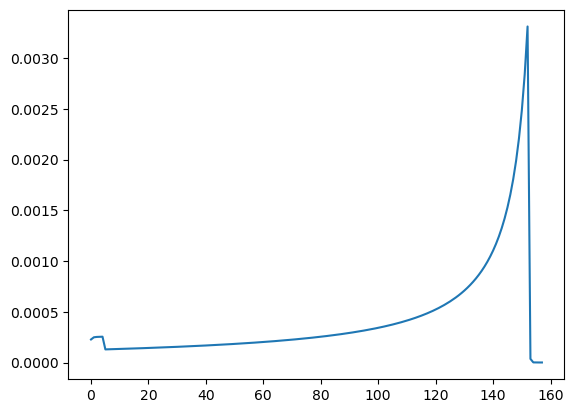

[6.765300627522267e-06, 0.0014634792554171214, 0.0012711479956527647, 0.0017735031045532934, 0.0011281941510479854, 0.002513118128718756, 0.001428823423592896, 0.0005971844579505455, 0.0009096104625163722, 0.0016123149689786192, 0.0007616002331166842, 0.000604799215775024, 0.0016868126063105228, 0.0013356266847450197, 0.001126502194399156, 0.0004263782629513966, 9.903382189056186e-09, 0.0003694371389523774, 4.870981301930595e-06, 0.0009546248744092571, 0.0009966767922817358, 6.550585307772412e-05, 2.5240081197371437e-09, 2.0660546090625715e-09, 2.0812215612399826e-07, 0.0004550259954025454, 0.00357002280031837, 7.962898079097684e-05, 0.0008987503966480865, 0.0006251800731954725, 0.0007196468047210995, 0.0007076308562782078, 0.0006206482643352117, 3.2934912723839155e-09, 5.665469343012216e-05, 0.00021242557497606605, 9.638157327786025e-05, 0.0010097822451658849, 2.517067835173867e-09, 2.5288614645394574e-09, 0.0007549041001442917, 0.0005342579465461617, 0.0014987184395293205, 2.52450589

In [261]:


df = mi.mice_df[0]  # Extract the first DataFrame
df_start_point = df.iloc[:, 4]  # Extract the relevant column

k_vals = pd.DataFrame(K_vals)
sigma_vals = pd.DataFrame(sigma_vals)

mask = k_vals.notna().all(axis=1)  # Create a row-wise mask (keep only rows where all values in k_vals are NOT NaN)
a=np.arange(0,df.shape[0]-1,1)
mask_2=a[mask]

K = k_vals[mask]  
sigma = sigma_vals[mask]  
df = df.loc[mask_2]  # Use .loc[] for proper row filtering


start=df_start_point[mask_2]
start = start.reset_index(drop=True)

for mouse in mice_diss:
    #Delete TREND column if you want to RERUN code DA TOGLIERE
    if 'TREND' in mouse.columns:
        mouse.drop('TREND', axis=1, inplace=True)
    
        
    # Calculate the threshold for the current species
    threshold_mouse = (threshold(start, K, sigma, df.iloc[:,4:]))

    print(threshold_mouse)
    
    ####################
    print(f"Processing mouse")
    ####################
    trend = []
    
    # Convert the species index to string (if needed)
    species = mouse.index.astype(str)
    c=-1
    for spec in species:      
        c+=1
        time_diss = mouse.loc[spec]        
        
        # Calculate the slope for real data (excluding the transient phase)
        slope_mouse, _, _, _, _ = linregress(np.arange(len(time_diss)), time_diss)
        
        # Compare the slope with the threshold to determine the trend
        if slope_mouse > threshold_mouse:
            trend.append("incr")  # Increasing
        else:
            trend.append("flat")  # Flat
    
    # Add the trend as a new column in the mouse DataFrame
    mouse["TREND"] = trend
    
    # Print or save the trends for the current mouse
    print(f"Trends for mouse appended to his dataframe")
    
    break
    

C:\Users\lucaf\AppData\Local\Temp\ipykernel_13460\42242502.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flat=size[0]/(size[0]+size[1])
C:\Users\lucaf\AppData\Local\Temp\ipykernel_13460\42242502.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  incr=size[1]/(size[0]+size[1])
C:\Users\lucaf\AppData\Local\Temp\ipykernel_13460\42242502.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"The number of flat species is: {s

The number of flat species is: 294, so it is the:46.96485623003195%
The number of increasing species is: 332, so it is the:53.03514376996805%


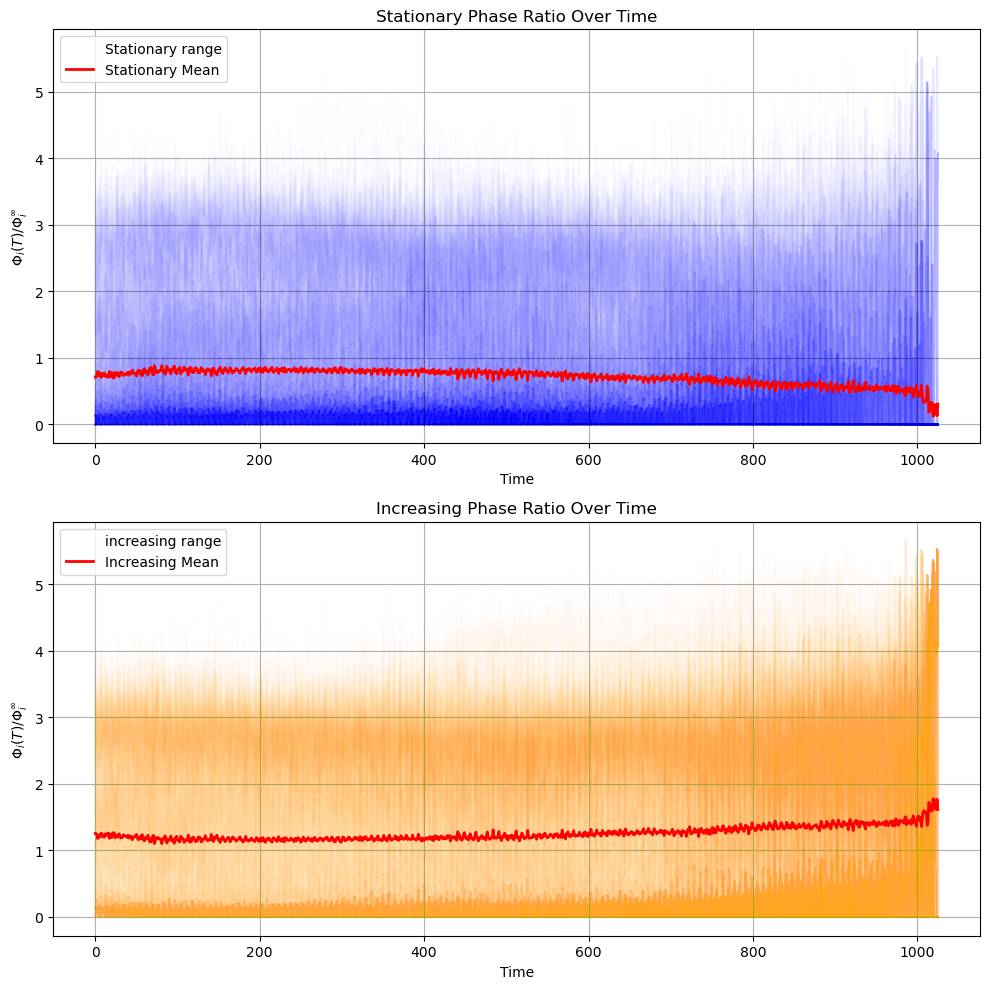

In [285]:
for mice in mice_diss:  
    size= mouse.groupby("TREND").size()
    flat=size[0]/(size[0]+size[1])
    incr=size[1]/(size[0]+size[1])
    print(f"The number of flat species is: {size[0]}, so it is the:{flat*100}%")
    print(f"The number of increasing species is: {size[1]}, so it is the:{incr*100}%")
    
    phi_inf=np.mean(mouse.iloc[:, :-1], axis=0)  
    ratio = mouse.iloc[:, :-1] / (phi_inf + 1e-4)  

    stationary_mask = (mouse["TREND"]=="flat") 
    ratio_stationary=pd.DataFrame(ratio[stationary_mask])

    increasing_mask = (mouse["TREND"]=="incr") 
    ratio_increasing=pd.DataFrame(ratio[increasing_mask])
    
    mean_ratio_stationary = ratio_stationary.mean(axis=0)
    mean_ratio_increasing = ratio_increasing.mean(axis=0)
  
    figure, axis = plt.subplots(2, 1, figsize=(10, 10))
    # --- Plot 1: Stationary Trend ---
    time_points = np.arange(0, len(mean_ratio_stationary), 1)
    
    # Plot individual lines for stationary
    for i in range(len(ratio_stationary)):        
        axis[0].plot(time_points, ratio_stationary.iloc[i], color='b', alpha=0.01, label="Stationary range" if i == 0 else None)  # Light blue individual lines

    # Plot mean line for stationary
    axis[0].plot(time_points, mean_ratio_stationary, label="Stationary Mean", color='red', linewidth=2)  # Bold mean line

    # Labels and title for stationary plot
    axis[0].set_xlabel("Time")
    axis[0].set_ylabel("$\\Phi_i(T)/\\Phi_i^\\infty$")
    axis[0].set_title("Stationary Phase Ratio Over Time")
    axis[0].legend()
    axis[0].grid(True)
    

    # --- Plot 2: Increasing Trend ---
    for i in range(len(ratio_increasing)):        
        axis[1].plot(time_points, ratio_increasing.iloc[i], color='orange', alpha=0.01,label="increasing range" if i == 0 else None)  # Light orange individual lines

    # Plot mean line for increasing
    axis[1].plot(time_points, mean_ratio_increasing, label="Increasing Mean", color='red', linewidth=2) 

    # Labels and title for increasing plot
    axis[1].set_xlabel("Time")
    axis[1].set_ylabel("$\\Phi_i(T)/\\Phi_i^\\infty$")
    axis[1].set_title("Increasing Phase Ratio Over Time")
    axis[1].legend()
    axis[1].grid(True)

    # Show the plots
    plt.tight_layout()
    plt.show()


    break  #DA TOGLIERE

##DA FARE PER TUTTI I TOPI; DA SALVARE LE IMMAGINI 


In [425]:
def tax(order):  #NON SONO SICURO CHE SIA DAVEVRO L'ORDINE
    unique_list=[]

    for i in order:
        taxo = i.split()[0]        
        if taxo not in unique_list:
            unique_list.append(taxo)
    return unique_list


    

In [448]:
import csv

bars=[] ###DA PRENDERE SOLO I NON STATIONARY
for i in range((8)):  
    
    path=f"Data/by_mouse/mouse_{i+1}.csv"
    file=pd.read_csv(path) 
    file_sorted = file.iloc[:, :4].sort_values(by=file.columns[2], ascending=False).head(10) # MEDIAN_COUNTS SORT. TAKE FIRST 5 VALUES 
    species=(list(file_sorted.iloc[0:,1]))
    #taxo=tax(species)
      
    med_dict = {}
    for i in range(len(species)):
        taxo = species[i].split()[0]   
       
        if taxo in med_dict:            
            med_dict[taxo] += file_sorted.iloc[i,2]
            
        else:
            med_dict[taxo] = file_sorted.iloc[i,2]
    bars.append(med_dict)
    


[{'Prevotella': 412.0, 'Parabacteroides': 205.5, 'Barnesiella': 267.5, 'Lactobacillus': 207.0, 'Tannerella': 104.5, 'Rikenella': 59.0, 'Bacteroides': 46.5}, {'Prevotella': 370.876404494382, 'Lactobacillus': 659.0, 'Parabacteroides': 149.0, 'Barnesiella': 229.0, 'Bacteroides': 57.0, 'Tannerella': 50.0}, {'Prevotella': 337.0, 'Lactobacillus': 663.0, 'Parabacteroides': 157.0, 'Barnesiella': 226.0, 'Coprobacter': 116.0}, {'Prevotella': 362.0, 'Lactobacillus': 701.0, 'Parabacteroides': 179.0, 'Barnesiella': 224.13316582914572, 'Coprobacter': 81.5}, {'Prevotella': 280.0, 'Lactobacillus': 628.0, 'Parabacteroides': 170.0, 'Coprobacter': 129.0, 'Barnesiella': 199.0}, {'Lactobacillus': 743.0, 'Prevotella': 257.5, 'Parabacteroides': 169.5, 'Barnesiella': 167.0, 'Bacteroides': 54.5, 'Coprobacter': 52.5}, {'Prevotella': 298.0, 'Lactobacillus': 628.0, 'Coprobacter': 199.5, 'Parabacteroides': 171.0, 'Barnesiella': 221.0, 'Bacteroides': 56.0}, {'Lactobacillus': 684.5, 'Prevotella': 244.5, 'Coprobacter

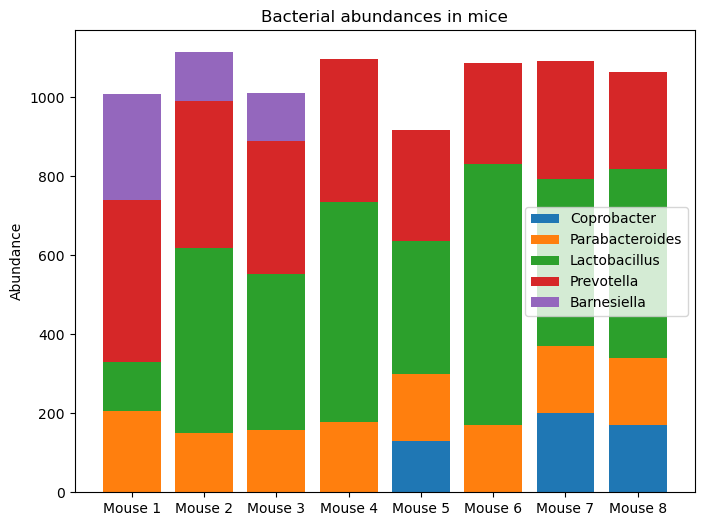

In [455]:

# Get all unique labels
labels = set()
for bar in bars:
    labels.update(bar.keys())
labels = list(labels)

n_mice = len(bars)  # Number of mice

# Create an array of zeros to start stacking the bars
bottom = np.zeros(n_mice)

# Create the figure
fig, ax = plt.subplots(figsize=(8, 6))

# Positions of the bars
x = np.arange(n_mice)

# Create the stacked bars
for label in labels:
    values = [mouse.get(label, 0) for mouse in bars]  # Get the values for each mouse
    bar_segments = ax.bar(x, values, label=label, bottom=bottom)  # Add the stacked bars
    bottom += values  # Update the "bottom" for stacking

# Labels and legend
ax.set_xticks(x)
ax.set_xticklabels([f'Mouse {i+1}' for i in range(n_mice)])
ax.set_ylabel('Abundance')
ax.set_title('Bacterial abundances in mice')
ax.legend()

plt.show()

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

        - if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
        so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

        calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.
